# 0. HuggingFace로 NLI 수행하기

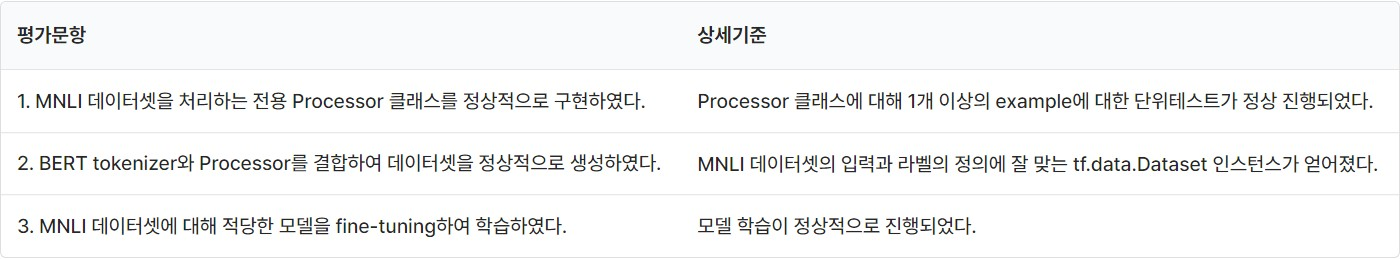

NLP Task를 편하게 할 수 있게 해주는 NLP Framework인 Huggingface transformers framework를 이용하여 커스텀 프로젝트를 구성해 보는 실습을 진행해 보겠습니다.

NLI는 Natural Language Inference(자연어 추론)의 줄임말로  
두 문장이 entailment(수반)하는지 neutral(중립)적인지 contradiction(모순)적인지  
분류하는 지도 학습입니다.

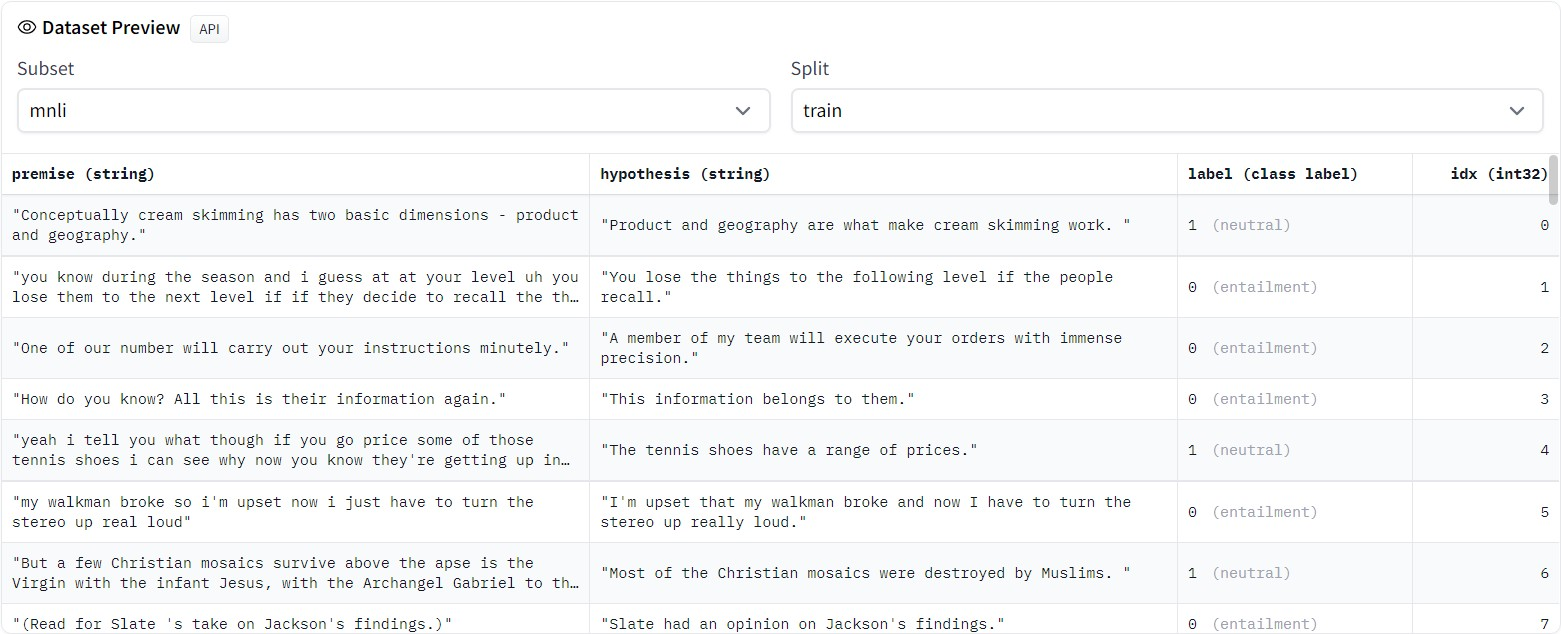

이번에 쓸 데이터셋은 MNLI인데 다양한 장르(Multi-genre)에서 가져온 데이터라는 뜻입니다.  
MNLI 데이터셋은 GLUE라는 포괄적인 데이터셋에 포함되어 있는데  
GLUE는 "강건하고 범용적인 자연어 이해 시스템의 개발"을 위해 제작되었다고 합니다.

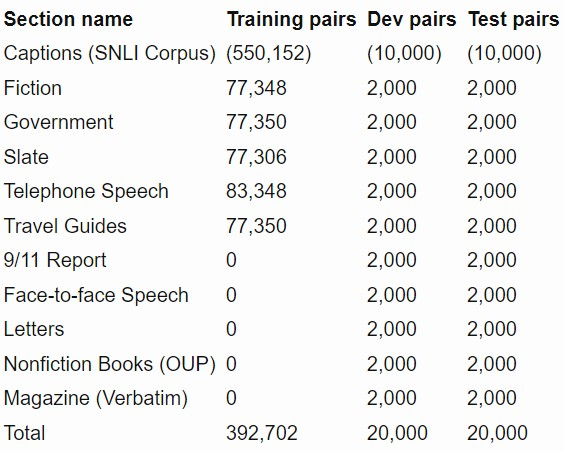

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from argparse import ArgumentParser
from dataclasses import asdict

import datasets
from datasets import load_dataset
from datasets import load_metric

import transformers
transformers.logging.set_verbosity_error()
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers.data.processors.utils import (
    DataProcessor, InputExample, InputFeatures
)


# 1. tensorflow datasets을 이용하는 방법

tensorflow datasets 패키지를 이용해서 MNLI 데이터셋을 불러옵니다.  
[glue/mnli 데이터 정보](https://huggingface.co/datasets/glue/viewer/mnli/train)

## 1.1. mnli 데이터셋을 분석해 보기

In [2]:
data, info = tfds.load('glue/mnli', with_info=True)
num_examples = info.splits['train'].num_examples
num_examples

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: glue/mnli/2.0.0
INFO:absl:Load dataset info from /tmp/tmp_l1i3niotfds
INFO:absl:Generating dataset glue (/aiffel/tensorflow_datasets/glue/mnli/2.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://dl.fbaipublicfiles.com/glue/data/MNLI.zip into /aiffel/tensorflow_datasets/downloads/dl.fbaipublicfiles.com_glue_MNLIdNe8cK2kTBCG0bqBz2JxwShRT2KfuO3NVIwROTnjtfI.zip.tmp.9c498375eb2a4727b9f5672514545ec2...


Generating splits...:   0%|          | 0/5 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/392702 [00:00<?, ? examples/s]

Shuffling glue-train.tfrecord...:   0%|          | 0/392702 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-train.tfrecord. Number of examples: 392702 (shards: [392702])


Generating validation_matched examples...:   0%|          | 0/9815 [00:00<?, ? examples/s]

Shuffling glue-validation_matched.tfrecord...:   0%|          | 0/9815 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-validation_matched.tfrecord. Number of examples: 9815 (shards: [9815])


Generating validation_mismatched examples...:   0%|          | 0/9832 [00:00<?, ? examples/s]

Shuffling glue-validation_mismatched.tfrecord...:   0%|          | 0/9832 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-validation_mismatched.tfrecord. Number of examples: 9832 (shards: [9832])


Generating test_matched examples...:   0%|          | 0/9796 [00:00<?, ? examples/s]

Shuffling glue-test_matched.tfrecord...:   0%|          | 0/9796 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-test_matched.tfrecord. Number of examples: 9796 (shards: [9796])


Generating test_mismatched examples...:   0%|          | 0/9847 [00:00<?, ? examples/s]

Shuffling glue-test_mismatched.tfrecord...:   0%|          | 0/9847 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-test_mismatched.tfrecord. Number of examples: 9847 (shards: [9847])
INFO:absl:Constructing tf.data.Dataset glue for split None, from /aiffel/tensorflow_datasets/glue/mnli/2.0.0


Dataset glue downloaded and prepared to /aiffel/tensorflow_datasets/glue/mnli/2.0.0. Subsequent calls will reuse this data.


392702

train 데이터셋의 길이는 392702입니다.

In [3]:
examples = data['train'].take(1)
print(examples)

<TakeDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>


변수는 총 4개입니다만 idx는 의미는 없습니다.  
premise(전제)에 대한 hypothesis(가설)이 수반, 중립, 모순되는지를 label로 분류합니다.

In [4]:
for example in examples:
    hypothesis = example['hypothesis']
    label = example['label']
    premise = example['premise']
    print(hypothesis)
    print(label)
    print(premise)

tf.Tensor(b'Meaningful partnerships with stakeholders is crucial.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', shape=(), dtype=string)


데이터를 직접 살펴봤습니다. 바이너리 인코딩이 되어있네요.

## 1.2. MNLIProcessor클래스 구현하기

데이터셋을 가공하는 일반적인 클래스 구조인 Processor를 생성하기 전에  
우선 추상클래스인 DataProcessor를 생성해보겠습니다.

In [5]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))
        

메소드들을 오버라이드한 MnliProcessor를 생성하겠습니다.  
MNLI 원본 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해 주는 클래스입니다.

In [6]:
class MnliProcessor(DataProcessor):
    """Processor for the MNLI data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["premise"].numpy().decode("utf-8"),
            tensor_dict["hypothesis"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1", "2"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


데이터를 한 번 살펴보겠습니다.

In [7]:
processor = MnliProcessor()

for example in examples:
    print('------원본데이터------')
    print(example)
    print('------processor 가공데이터------')
    example = processor.get_example_from_tensor_dict(example)
    print(example)
    print('------tfds_map 가공데이터------')
    example = processor.tfds_map(example)
    print(example)

------원본데이터------
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>, 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}
------processor 가공데이터------
InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeh

In [8]:
label_list = processor.get_labels()
label_list

['0', '1', '2']

## 1.3. Huggingface DistilBert tokenizer를 활용하여 데이터셋 구성하기

processor가 생성한 example을 tokenizer로 인코딩하여 feature로 변환하는 역할을 하는 함수를 생성하겠습니다.

In [10]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features


위 함수를 호출해서 얻은 feature를 바탕으로 tf.data.Dataset을 생성하여 리턴해주는 함수를 생성하겠습니다.

In [11]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )


NLP 모델링의 핵심을 이루는 Tokenizer와 Model은 framework에서 이미 잘 만들어져 있는 것을 쉽게 가져다 쓸 수 있습니다.  
[distilbert-base-uncased-mnli 모델 정보](https://huggingface.co/typeform/distilbert-base-uncased-mnli)  
(퍼래머더 개수: 기본(base), 대소문자: 구분 안됨(uncased), 데이터 종류: Multi-Genre)

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('typeform/distilbert-base-uncased-mnli')


In [12]:
batch_size = 16

train, validation, test 데이터셋을 생성합니다. 최대 128 토큰으로 자릅니다.  
데이터도 섞어주고(shuffle) 배치 사이즈로 나눕니다.

In [13]:
# train 데이터셋
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(len(data['train'])).batch(batch_size)


Using label list ['0', '1', '2']
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 1999, 5038, 1997, 2122, 13136, 1010, 1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, 10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, 22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, 1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 15902, 13797, 2007, 22859, 2003, 10232, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [14]:
examples = train_dataset.take(1)
for example in examples:
    print(example)

({'input_ids': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1999,  5038,  1997,  2122, 13136,  1010,  1048, 11020,
        2038,  2499, 29454, 29206, 14626,  2144,  2786,  2000, 16636,
        1996, 10908,  1997,  1996,  2110,  4041,  6349,  1998,  2000,
        5323, 15902, 13797,  2007, 22859,  6461,  2012,  6469,  2075,
        1037,  2047, 25353, 14905, 10735,  2483,  2090,  1996,  2976,
       10802,  1998, 15991,  1997,  3423,  2578,  4804,  1012,   102,
       15902, 13797,  2007, 22859,  2003, 10232,  1012,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

In [15]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation_matched'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(len(data['validation_matched'])).batch(batch_size)


Using label list ['0', '1', '2']
*** Example ***
guid: 6287
features: InputFeatures(input_ids=[101, 7910, 1011, 9616, 2821, 3398, 2035, 1996, 2111, 2005, 2157, 7910, 2166, 2030, 2242, 102, 3398, 7167, 1997, 2111, 2005, 1996, 2157, 2166, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=0)
*** Example ***
g

In [16]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test_matched'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(len(data['test_matched'])).batch(batch_size)


Using label list ['0', '1', '2']
*** Example ***
guid: 5398
features: InputFeatures(input_ids=[101, 2092, 2003, 2045, 1037, 2210, 3751, 10216, 2017, 2404, 1999, 2045, 102, 2003, 2045, 1037, 10216, 2008, 2017, 2404, 1999, 2045, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=2)
*** Example ***
gu

## 1.4. Huggingface DistilBert model을 생성하여 학습 및 테스트를 진행해 보기

학습은 tf.keras.model의 fit 메소드를 이용합니다.

In [17]:
model = TFDistilBertForSequenceClassification.from_pretrained('typeform/distilbert-base-uncased-mnli')


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [19]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  2307      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


학습 시작!

In [20]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
model.fit(train_dataset_batch, epochs=1, # steps_per_epoch=num_examples//batch_size,
                validation_data=validation_dataset_batch)


24544/24544 [==============================] - 5359s 210ms/step - loss: 0.2887 - acc: 0.8933 - val_loss: 0.5578 - val_acc: 0.8087


validation accuracy가 0.8로 성능이 그럭저럭 잘 나온 것 같습니다.

In [21]:
result = model.evaluate(test_dataset_batch)
print(result)

613/613 [==============================] - 49s 72ms/step - loss: 3.0294 - acc: 0.3290
[3.029386281967163, 0.32901182770729065]


In [22]:
output_dir = os.getenv('HOME')+'/aiffel/transformers/checkpoint'
output_eval_file = os.path.join(output_dir, "eval_results.txt")

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(result) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))

#파일에 쓴 테스트 결과 확인
!cat ~/aiffel/transformers/checkpoint/eval_results.txt

cat: /aiffel/aiffel/transformers/eval_results.txt: No such file or directory


하지만 test accuracy는 매우 낮은데 이유는 모르겠습니다...  
레이블 개수가 3개인 분류기의 정확도가 33%면 분류기가 아예 제대로 동작하지 않는다는 것입니다.

In [31]:
y_pred = model.predict(test_dataset_batch)
print(y_pred[0])

array([[-4.1829033 ,  3.027038  ,  0.73558205],
       [-2.431665  ,  2.4333568 , -0.22945581],
       [-0.5169676 , -1.0513422 ,  1.1068053 ],
       ...,
       [-1.4881251 ,  3.2385142 , -2.6566043 ],
       [-3.444838  ,  1.3351057 ,  1.6825261 ],
       [ 0.15066421,  1.7755383 , -2.637101  ]], dtype=float32)

예측값도 뽑아봤는데 값이 이상합니다.  
분류 문제라서 소프트맥스값을 예상했는데  
음수값도 들어있고 더해서 1이 안나옵니다.  
이래서 test accuracy 저모양이었던 것입니다.  
돌이켜보니 모델의 마지막 레이어가 Dense여서 어쩌면 당연한 것 같습니다.  
근데 그러면 validation accuracy도 제대로 안나와야 될 것 같은데 이건 잘나오니 의아합니다.  
이부분은 나중에 관련된 코드 예시가 있으면 풀어봐야겠습니다.

In [23]:
#메모리를 비워줍니다.
del data
del tokenizer
del train_dataset
del train_dataset_batch
del validation_dataset
del validation_dataset_batch
del test_dataset
del test_dataset_batch
del model

# 2. huggingface datasets을 이용하는 방법

huggingface datasets 패키지를 이용해서 MNLI 데이터셋을 불러옵니다.
데이터는 tensorflow datasets 패키지를 이용해서 불러온 MNLI와 동일합니다.

## 2.1. mnli 데이터셋을 분석해 보기

In [24]:
huggingface_mnli_dataset = load_dataset('glue', 'mnli')
print(huggingface_mnli_dataset)

  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


In [25]:
examples = huggingface_mnli_dataset['train'][0]
print(examples)

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'idx': 0, 'label': 1}


데이터가 이미 processing이 되어있어서 1번 방법에서 썼던 processor를 사용하지 않고 바로 토크나이징으로 넘어가면 될 것 같습니다.

## 2.2. Huggingface Auto Tokenizer를 활용하여 데이터셋 구성하기

Huggingface에는 Auto Class가 있는데 이 클래스는 pretrained model의 경로 혹은 이름만 안다면 자동으로 해당 모델을 위한 함수를 생성해주는 클래스입니다.  
정확한 클래스명을 알 수 없을 때 쓰면 좋은 방법입니다.  
다시말하면 이 태스크에서는 AutoTokenizer와 DistilBertTokenizer가 같다고 볼 수 있습니다.  
따라서 이번에는 AutoTokenizer를 사용해보겠습니다.  

In [3]:
# huggingface_tokenizer = DistilBertTokenizer.from_pretrained('typeform/distilbert-base-uncased-mnli')
huggingface_tokenizer = AutoTokenizer.from_pretrained('typeform/distilbert-base-uncased-mnli')


Downloading:   0%|          | 0.00/258 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/776 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

1번 방법에서 최대 토큰의 길이를 128로 잡았으므로 이번에도 똑같이 128로 자르겠습니다.

In [7]:
def transform(data):
    return huggingface_tokenizer(
        data['premise'],
        data['hypothesis'],
        padding = 'max_length',
        truncation = True,
        max_length = 128,
        return_token_type_ids = False
    )

In [8]:
examples = huggingface_mnli_dataset['train'][:5]
examples_transformed = transform(examples)

print(examples)
print(examples_transformed)

{'premise': ['Conceptually cream skimming has two basic dimensions - product and geography.', 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'One of our number will carry out your instructions minutely.', 'How do you know? All this is their information again.', "yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range"], 'hypothesis': ['Product and geography are what make cream skimming work. ', 'You lose the things to the following level if the people recall.', 'A member of my team will execute your orders with immense precision.', 'This information belongs to them.', 'The tennis shoes have a range of prices.'], 'label': [1, 0, 0, 0, 1], 'idx': [0, 1, 2, 3, 4]}
{'inp

모델에 들어갈 최종 데이터셋을 생성합니다.  
1번 방법과는 달리 하나의 데이터셋 안에 train, validation, test가 한꺼번에 들어가 있는 모양새입니다.

In [9]:
encoded_dataset = huggingface_mnli_dataset.map(transform, batched=True)

  0%|          | 0/393 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

## 2.3. Huggingface Auto model을 생성하여 학습 및 테스트를 진행해 보기

학습은 transformers.trainer의 train 메소드를 이용합니다.

이 태스크에서는 AutoModelForSequenceClassification와 TFDistilBertForSequenceClassification이 같다고 볼 수 있습니다.  
따라서 이번에는 AutoTokenizer를 사용해보겠습니다.

In [10]:
# huggingface_model = TFDistilBertForSequenceClassification.from_pretrained('typeform/distilbert-base-uncased-mnli')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('typeform/distilbert-base-uncased-mnli', num_labels = 3)


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

1번 방법과 똑같이 배치 사이즈를 16으로 주고 학습률도 동일하게 맞추겠습니다.

In [11]:
batch_size = 16

In [12]:
output_dir = os.getenv('HOME')+'/aiffel/transformers/checkpoint'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 3e-5, #learning_rate
    per_device_train_batch_size = batch_size, # 각 device 당 batch size
    per_device_eval_batch_size = batch_size, # evaluation 시에 batch size
    num_train_epochs = 1, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
)

In [13]:
metric = load_metric('glue', 'mnli')

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [14]:
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

학습 시작!

In [15]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['validation_matched'],       # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()


The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hypothesis, idx, premise.
***** Running training *****
  Num examples = 392702
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 24544
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json


{'loss': 0.222, 'learning_rate': 2.9388852672750976e-05, 'epoch': 0.02}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json


{'loss': 0.2184, 'learning_rate': 2.877770534550196e-05, 'epoch': 0.04}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json


{'loss': 0.2392, 'learning_rate': 2.8166558018252934e-05, 'epoch': 0.06}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json


{'loss': 0.2412, 'learning_rate': 2.7555410691003913e-05, 'epoch': 0.08}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2500/config.json


{'loss': 0.2426, 'learning_rate': 2.694426336375489e-05, 'epoch': 0.1}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3000/config.json


{'loss': 0.2543, 'learning_rate': 2.6333116036505867e-05, 'epoch': 0.12}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3500/config.json


{'loss': 0.2611, 'learning_rate': 2.5721968709256846e-05, 'epoch': 0.14}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-3500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-4000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-4000/config.json


{'loss': 0.2539, 'learning_rate': 2.511082138200782e-05, 'epoch': 0.16}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-4000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-4500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-4500/config.json


{'loss': 0.259, 'learning_rate': 2.4499674054758804e-05, 'epoch': 0.18}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-4500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-5000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-5000/config.json


{'loss': 0.2543, 'learning_rate': 2.388852672750978e-05, 'epoch': 0.2}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-5500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-5500/config.json


{'loss': 0.2767, 'learning_rate': 2.3277379400260758e-05, 'epoch': 0.22}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-5500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-6000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-6000/config.json


{'loss': 0.254, 'learning_rate': 2.2666232073011734e-05, 'epoch': 0.24}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-6000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-6500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-6500/config.json


{'loss': 0.2717, 'learning_rate': 2.2055084745762713e-05, 'epoch': 0.26}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-6500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-7000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-7000/config.json


{'loss': 0.2476, 'learning_rate': 2.144393741851369e-05, 'epoch': 0.29}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-7000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-7500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-7500/config.json


{'loss': 0.2661, 'learning_rate': 2.0832790091264667e-05, 'epoch': 0.31}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-7500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8000/config.json


{'loss': 0.2663, 'learning_rate': 2.0221642764015646e-05, 'epoch': 0.33}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-8000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8500/config.json


{'loss': 0.2607, 'learning_rate': 1.9610495436766625e-05, 'epoch': 0.35}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-8500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-9000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-9000/config.json


{'loss': 0.2446, 'learning_rate': 1.89993481095176e-05, 'epoch': 0.37}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-9000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-9500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-9500/config.json


{'loss': 0.261, 'learning_rate': 1.838820078226858e-05, 'epoch': 0.39}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-9500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-10000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-10000/config.json


{'loss': 0.2525, 'learning_rate': 1.7777053455019558e-05, 'epoch': 0.41}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-10500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-10500/config.json


{'loss': 0.2594, 'learning_rate': 1.7165906127770537e-05, 'epoch': 0.43}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-10500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-11000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-11000/config.json


{'loss': 0.2565, 'learning_rate': 1.6554758800521512e-05, 'epoch': 0.45}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-11000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-11500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-11500/config.json


{'loss': 0.2521, 'learning_rate': 1.5943611473272488e-05, 'epoch': 0.47}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-11500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-12000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-12000/config.json


{'loss': 0.2371, 'learning_rate': 1.533246414602347e-05, 'epoch': 0.49}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-12000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-12500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-12500/config.json


{'loss': 0.2411, 'learning_rate': 1.4721316818774445e-05, 'epoch': 0.51}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-12500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-13000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-13000/config.json


{'loss': 0.2533, 'learning_rate': 1.4110169491525424e-05, 'epoch': 0.53}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-13000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-13500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-13500/config.json


{'loss': 0.2503, 'learning_rate': 1.3499022164276401e-05, 'epoch': 0.55}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-13500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-14000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-14000/config.json


{'loss': 0.2539, 'learning_rate': 1.288787483702738e-05, 'epoch': 0.57}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-14000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-14500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-14500/config.json


{'loss': 0.2364, 'learning_rate': 1.2276727509778357e-05, 'epoch': 0.59}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-15000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-15000/config.json


{'loss': 0.2543, 'learning_rate': 1.1665580182529336e-05, 'epoch': 0.61}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-15500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-15500/config.json


{'loss': 0.246, 'learning_rate': 1.1054432855280312e-05, 'epoch': 0.63}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-15500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-16000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-16000/config.json


{'loss': 0.2428, 'learning_rate': 1.044328552803129e-05, 'epoch': 0.65}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-16000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-16500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-16500/config.json


{'loss': 0.2332, 'learning_rate': 9.83213820078227e-06, 'epoch': 0.67}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-16500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-17000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-17000/config.json


{'loss': 0.2182, 'learning_rate': 9.220990873533247e-06, 'epoch': 0.69}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-17000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-17500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-17500/config.json


{'loss': 0.2376, 'learning_rate': 8.609843546284226e-06, 'epoch': 0.71}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-17500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-18000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-18000/config.json


{'loss': 0.2246, 'learning_rate': 7.998696219035203e-06, 'epoch': 0.73}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-18000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-18500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-18500/config.json


{'loss': 0.2297, 'learning_rate': 7.38754889178618e-06, 'epoch': 0.75}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-18500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-19000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-19000/config.json


{'loss': 0.2371, 'learning_rate': 6.776401564537158e-06, 'epoch': 0.77}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-19000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-19500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-19500/config.json


{'loss': 0.221, 'learning_rate': 6.165254237288136e-06, 'epoch': 0.79}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-19500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-20000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-20000/config.json


{'loss': 0.2324, 'learning_rate': 5.554106910039114e-06, 'epoch': 0.81}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-20000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-20500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-20500/config.json


{'loss': 0.231, 'learning_rate': 4.942959582790091e-06, 'epoch': 0.84}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-20500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-21000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-21000/config.json


{'loss': 0.2239, 'learning_rate': 4.331812255541069e-06, 'epoch': 0.86}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-21000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-21500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-21500/config.json


{'loss': 0.2307, 'learning_rate': 3.720664928292047e-06, 'epoch': 0.88}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-21500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-22000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-22000/config.json


{'loss': 0.2212, 'learning_rate': 3.109517601043025e-06, 'epoch': 0.9}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-22000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-22500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-22500/config.json


{'loss': 0.2225, 'learning_rate': 2.498370273794003e-06, 'epoch': 0.92}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-22500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-23000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-23000/config.json


{'loss': 0.2227, 'learning_rate': 1.8872229465449805e-06, 'epoch': 0.94}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-23000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-23500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-23500/config.json


{'loss': 0.2239, 'learning_rate': 1.2760756192959583e-06, 'epoch': 0.96}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-23500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-24000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-24000/config.json


{'loss': 0.2261, 'learning_rate': 6.649282920469362e-07, 'epoch': 0.98}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-24000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-24500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-24500/config.json


{'loss': 0.2245, 'learning_rate': 5.378096479791395e-08, 'epoch': 1.0}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-24500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hypothesis, idx, premise.
***** Running Evaluation *****
  Num examples = 9815
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.6941453218460083, 'eval_accuracy': 0.8191543555781966, 'eval_runtime': 37.0477, 'eval_samples_per_second': 264.929, 'eval_steps_per_second': 16.573, 'epoch': 1.0}
{'train_runtime': 4658.9705, 'train_samples_per_second': 84.289, 'train_steps_per_second': 5.268, 'train_loss': 0.24265429968162497, 'epoch': 1.0}


TrainOutput(global_step=24544, training_loss=0.24265429968162497, metrics={'train_runtime': 4658.9705, 'train_samples_per_second': 84.289, 'train_steps_per_second': 5.268, 'train_loss': 0.24265429968162497, 'epoch': 1.0})

eval_accuracy 0.82로 1번 방법보다 좀 더 잘나온 것을 볼 수 있습니다.  
1번 방법과 모델을 최대한 비슷하게 만들긴 했지만 역시 세부적으로 조금 다르게 생겨먹은 것 같습니다.

In [21]:
trainer.evaluate(encoded_dataset['test_matched'])

THCudaCheck FAIL file=../aten/src/THC/THCCachingHostAllocator.cpp line=278 error=710 : device-side assert triggered


RuntimeError: cuda runtime error (710) : device-side assert triggered at ../aten/src/THC/THCCachingHostAllocator.cpp:278

마찬가지로 evaluate를 해보려했지만 에러가 발생했습니다.  
찾아보니까 label값이 범위를 벗어나면 생기는 문제라고 합니다.

https://koreapy.tistory.com/1748  
https://github.com/pytorch/pytorch/issues/25537  
https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/157

실제로 데이터도 찾아보니 테스트 데이터셋의 label이 정말로 범위를 벗어난 -1값으로만 채워져있는 것을 찾아냈습니다.

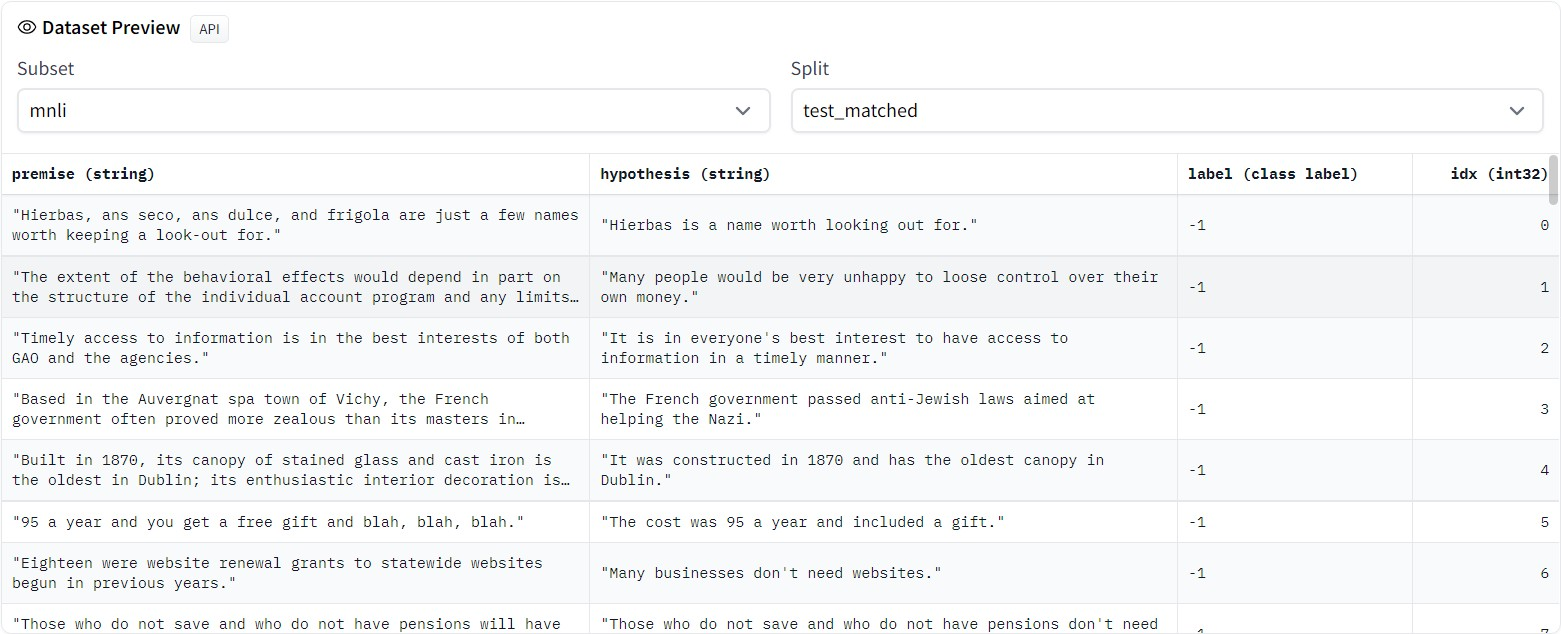

In [32]:
trainer.predict(encoded_dataset['test_matched'])

RuntimeError: cuda runtime error (710) : device-side assert triggered at ../aten/src/THC/THCCachingHostAllocator.cpp:278

predict는 label값이 필요없어서 가능할 줄 알았지만 여전히 같은 에러가 떴습니다.  
일단 테스트 데이터셋에 label -1값이 들어있기는 해서 오류가 발생하는 것 같습니다.

# 5. 회고하기

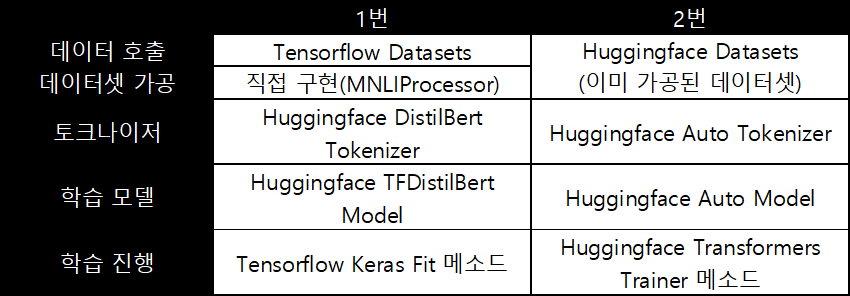

predict값이 제대로 나와야 깔끔하게 프로젝트를 마무리했다는 느낌을 받는데  
이번에는 1번 방법으로는 accuracy가 완전이 맛이 가있고  
2번 방법으로는 아예 오류가 떠버려서 매우 찝찝하게 마무리 한 것 같습니다.  
그래도 이번에 제대로 pretraining을 해볼 수 있어서 만족스러웠고  
특히 이미 가공되어있는 데이터를 불러오기 때문에 과정이 매우 간편하다는 것이 마음에 들었습니다.  
다만 학습을 진행시켜주는 Trainer 메소드는 지금까지 썼던 tensorflow의 fit 메소드와 많이 달라서 익숙해져야 할 필요가 있는 것 같습니다.